# About Jupyter Notebook
For some of you, this might be your first time using a Jupyter notebook. Here are a few tips to get you started!

A Jupyter notebook is a file with the .ipynb extension, just like this one. It's made up of *cells*, which can be:
- Code cells - where you write your code
- Markdown cells - where you write formatted text (like this section!)

Code cell are labeled with `[ ]` on the left. When a cell is running, the label changes to `[*]`. The number inside the brackets shows the order in which cells have been executed by the *kernel*.

So, what is the kernel? The kernel is the coputational 'engine' that runs the code. This notebook is connected to a Python kernel.

### Useful Keyboard Shortcuts
Jupyter notebooks offer helpful keyboard shortcuts that may save your time. First, make sure you are in *command mode* (not editing a cell). Press <kbd>Esc</kbd> or click outside the cell to exit *edit mode*.

Here are some handy shortcuts:
- Insert a new cell above or below → press <kbd>A</kbd> or <kbd>B</kbd>
- Delete a cell → press <kbd>D</kbd> twice (Note: Deleted cells cannot be recovered!)
- Restart the kernel and run all cells → press <kbd>0</kbd> twice (this is a zero!)
- Run the selected cell → press <kbd>Ctrl</kbd> + <kbd>Enter</kbd>
- Run the selected cell and move to the next cell → press <kbd>Shift</kbd> + <kbd>Enter</kbd>

Please check out the toolbar and menu bar at the top of the notebook for more options.

# Awkward Arrays
This lab uses a library called **Awkward Array**. Like Numpy, Awkward Arrays can have multiple dimensions. However, unlike Numpy, Awkward arrays support dimensions with *varying lengths*, making them ideal for handling irregular or nested data in particle physics experiments.
### Structured Data in Awkward Arrays
This lab uses structured data, where each element is a *record* with named fields (similar to a dictionary). For example:
```
array1 = ak.Array([{
    'a': [1, 2, 3],
    'b': 4,
    'c': [5, 6]
}])
```
This array `array1` contains *one* record with three fields: `'a'`, `'b'`, and `'c'`. You can access the list of fields with `array1.fields`.
### Concatenating Awkward Arrays
To combine two Awkward arrays with matching structure, use `ak.concatenate()`. An example:
```
array2 = ak.Array([{
    'a': [7, 8],
    'b': 9,
    'c': [10, 11, 12]
}])

ak.concatenate([array1, array2])
```
This results in a single Awkward Array with *two* records:
```
[
    {'a': [1, 2, 3], 'b': 4, 'c': [5, 6]},
    {'a': [7, 8],    'b': 9, 'c': [10, 11, 12]}
]
```
For more information about Awkward Arrays: https://awkward-array.org/doc/main/

# The Experiment
This experiment uses custom modules in the *backend* folder, which have been specifically developed for this third-year lab. This notebook works with **pre-processed data** derived from the **13 TeV 2025 ATLAS Open Data**.

Please run the cell below to install the required packages. You will need to do this **each time you start the server**.

In [1]:
!pip install atlasopenmagic
!pip install pyarrow==20.0.0

from atlasopenmagic import install_from_environment
install_from_environment(environment_file="environment.yml")

Installing packages: ['aiohttp>=3.9.5', 'atlasopenmagic', 'awkward==2.8.5', 'awkward-pandas>=2023.8.0', 'coffea~=0.7.0', 'hist>=2.8.0', 'ipykernel>=6.29.5', 'jupyter>=1.0.0', 'lmfit>=1.3.2', 'matplotlib>=3.9.1', 'metakernel>=0.30.2', 'notebook>=7', 'numpy>=1.26.4', 'pandas>=2.2.2', 'papermill>=2.6.0', 'pip>=24.2', 'scikit-learn>=1.5.1', 'uproot>=5.3.10', 'uproot3>=3.14.4', 'fsspec-xrootd>=0.5.1', 'jupyterlab_latex>=3.1.0', 'vector>=1.4.1']
  Using cached coffea-0.7.30-py2.py3-none-any.whl.metadata (9.6 kB)
  Using cached numpy-2.3.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
INFO: pip is looking at multiple versions of coffea to determine which version is compatible with other requirements. This could take a while.
  Using cached coffea-0.7.29-py2.py3-none-any.whl.metadata (9.6 kB)
  Using cached coffea-0.7.28-py2.py3-none-any.whl.metadata (9.6 kB)
  Using cached coffea-0.7.27-py2.py3-none-any.whl.metadata (9.6 kB)
  Using cached coffea-0.7.26-py2.py3-

Next, run the cell below to import the required modules and functions for the experiment. Repeat this step **every time you restart the kernel**.

In [2]:
import os
import re
import awkward as ak
import time
import datetime
from zoneinfo import ZoneInfo
import uproot
import glob
import numpy as np
import vector
import hist
from hist import Hist
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator # for minor ticks
from lmfit.models import PolynomialModel, GaussianModel
import pyarrow.parquet as pq

from backend import get_valid_variables, validate_read_variables
from backend import plot_stacked_hist, plot_histograms, histogram_2d, plot_errorbars
from backend import get_histogram, analysis_parquet

## Accessing Data Samples
Data samples stored in the *backend* folder can be accessed using a *string code*. The available string codes are listed below:  
#### Available Final-State Collections (Real Data)
* `'2to4lep'` - Events with two to four leptons, each with at least 7 GeV of transverse momentum $p_T$
* `'GamGam'` - Events with at least two photons, each with at least 25 GeV of $p_T$

#### Available Monte Carlo Simulation Datasets
* `'Zee'` - Simulated $Z \rightarrow e^+e^-$ events
* `'Zmumu'` - Simulated $Z \rightarrow \mu^+\mu^-$ events
* `'Hyy'` - Simulated $H \rightarrow \gamma \gamma$ events

To combine multiple datasets, combine the string codes using `'+'`. For example, if you would like to combine the $Z \rightarrow \mu^+\mu^-$ and $Z \rightarrow e^+e^-$ datasets, use the string code `'Zee+Zmumu'`.  
The sample files in the backend contain a few important variables. You can view the available variables using the `get_valid_variables` function that is defined in the backend. An example is shown in the code cell below.

In [3]:
string_code = 'GamGam'
get_valid_variables(string_code)

['photon_pt',
 'photon_eta',
 'photon_phi',
 'photon_e',
 'photon_ptcone20',
 'photon_topoetcone40',
 'photon_isLooseID',
 'photon_isTightID',
 'photon_isLooseIso',
 'photon_isTightIso',
 'photon_n',
 'trigP']

The `analysis_parquet` function reads datasets specified by the `string_code_list` input and returns a dictionary containing the selected data. The parameter `fraction` determines the fraction of each dataset to load; the default value is `1`. For Higgs analysis, it is recommended to start with `fraction = 0.1` or lower to reduce memory usage.

In [4]:
string_code_list = ['GamGam', 'Hyy'] # List of dataset codes to load
read_variables = ['photon_n', 'photon_pt']
fraction = 0.1 # Fraction of each dataset to load
# Call analysis_parquet to read the datasets and return the data as a dictionary
data = analysis_parquet(read_variables, string_code_list, fraction=fraction)
data

Input string_code_list found. Data samples will be accessed by the string code(s).
Elapsed time = 1.0s


{'GamGam_0_1': <Array [{photon_pt: [...], ...}, ..., {...}] type='3656414 * {photon_pt: va...'>,
 'Hyy_0_1': <Array [{photon_pt: [...], ...}, ..., {...}] type='39784 * {photon_pt: var ...'>}

As shown in the example above, the `analysis_parquet` function returns a dictionary where:
- **Keys** are constructed by combining each dataset code from `string_code_list` with the `fraction` (e.g. for `GamGam` and `fraction = 0.1`, the key is `'GamGam_0_1`)
- **Values** are Awkward Arrays, where each entry corresponds to an event represented as a record (similar to a Python dictionary). The fields in each record correspond to the variables listed in `read_variables`.

For example, the dictionary returned by the `analysis_parquet` may look like this:
```
data = {
    'GamGam_0_1': Array([
        {'photon_n': 2, 'photon_pt': [106, 47.6]},
        {'photon_n': 2, 'photon_pt': [41.6, 37.3]},
    ]),
    'Hyy_0_1': Array([
        ...
    ])
}
```

Let's interpret the first event in the `'GamGam_0_1'` dataset, which is represented by the first record in the Awkward Array stored under the `'GamGam_0_1'` key (i.e., `data['GamGam_0_1']`).
- The number of photons in this event is 2 (`photon_n : 2`)
- The field `photon_pt` lists their transverse momenta: The first photon has $p_T = 106$ GeV, and the second photon has $p_T = 47.6$ GeV.

To extract the $p_T$ of the first photon from all events in the `'GamGam_0_1'` dataset, use  
`data['GamGam_0_1']['photon_pt'][:, 0]`.

In [5]:
data['GamGam_0_1']['photon_pt'][:, 0] # pT of the first photon from all events

<Array [106, 41.6, 45.2, 97.5, ..., 65.7, 54.8, 50.8] type='3656414 * float32'>

## Event Weights
MC data is generated under ideal conditions, but the real ATLAS detector has inefficiencies and limitations. To make meaningful comparisons between simulation and data, each MC event is assigned a *weight* that reflects its relative contribution to the histogram count for its bin. 

The `analysis_parquet` function returns a variable called `totalWeight` variable for MC datasets. This variable represents the combined weight for each simulated event calculated from several 'weight variables', including:
- The MC weight asscociated with each event
- Scale factors for detector efficiency and resolution
- The efficiency of simulated process
- The cross section of simulated process and its corrections

You don't need to explicitly include `'totalWeight'` in `read_variables`. If the field is present in the data (i.e. in MC samples), `analysis_parquet` will return it automatically.

Check out the `EventWeights` module in the backend folder if you're curious how the variable is calculated!

## Event Selection

You can also perform event selection by defining a custom *cut function*, which can be passed to `analysis_parquet` via the `cut_function` argument. This function takes the full dataset as input and returns a filtered version according to your selection criteria. In addition, you can compute new variables and store them as new fields in the event records within the cut function. 

The example below selects events with exactly two final-state photons. It then computes the invariant mass by summing their four-momentum vectors and accessing the `.M` attribute as implemented in the `yy_cut` function. This function is passed to the `analysis_parquet` via the `cut_function` argument.

In [6]:
# Variables to read from the dataset
read_variables = ['photon_pt', 'photon_eta', 'photon_phi', 'photon_e',
                  'photon_n', 'mass']
# You may also use the pre-defined function `validate_read_variables` to
# validate your `read_variables`. This will remove 'mass' from read_variables
read_variables = validate_read_variables(string_code_list, read_variables)

# Custom selection cut function to filter the data
def yy_cut(data):
    # Cut on photon number
    cut_photon_n = (data['photon_n'] == 2) # Define mask
    data = data[cut_photon_n] # Only keep events that have two photons

    # Cut on photon pt
    photon_pt0 = data['photon_pt'][:, 0] 
    photon_pt1 = data['photon_pt'][:, 1]
    # Use bitwise operator '&' for AND, '|' for OR. Remember the parentheses!
    cut_photon_pt = (photon_pt0 > 20) & (photon_pt1 > 20)
    data = data[cut_photon_pt] # Keep events where two photons have pt > 20 GeV

    # Define four momentum
    four_momentum = vector.zip({
        'pt': data['photon_pt'],
        'eta' : data['photon_eta'],
        'phi' : data['photon_phi'],
        'E' : data['photon_e']
    })
    # Add the 4-momentum of the two photons in each event and get the 
    # invariant mass using .M
    data['mass'] = (four_momentum[:, 0] + four_momentum[:, 1]).M
    
    return data

fraction = 0.1
data = analysis_parquet(read_variables, string_code_list, fraction=fraction,
                        cut_function=yy_cut)

Skipping 'mass' - invalid input for string code 'GamGam'
Skipping 'mass' - invalid input for string code 'Hyy'
Input string_code_list found. Data samples will be accessed by the string code(s).
Elapsed time = 2.1s


If you only need data for a specific photon — for example, the $p_T$ of the first photon — you can include `'photon_pt[0]'` in `read_variables` instead of `'photon_pt'`. This saves memory by storing the data as a flat array rather than a nested one. However, do this only if `'photon_pt'` is not required elsewhere, such as in the cut function.

## Plot Stacked Histogram
The dictionary returned by `analysis_parquet` can be used to plot a stacked histogram by passing it to the `plot_stacked_hist` function.

To use this function correctly, there are a few points to take note of:
- The first argument must be a dictionary.
- If a dictionary key includes `'Data'`, its content will be plotted as data points with error bars.
- If a dictionary key includes `'Signal'`, its content will be stacked as histogram bars on top of the background.
- Python strings are case-sensitive, i.e. `'Data'` and `'data'` are treated differently!

An example is shown below, where `'GamGam'` is treated as data and `'Hyy'` as the signal.

Elapsed time = 0.4s


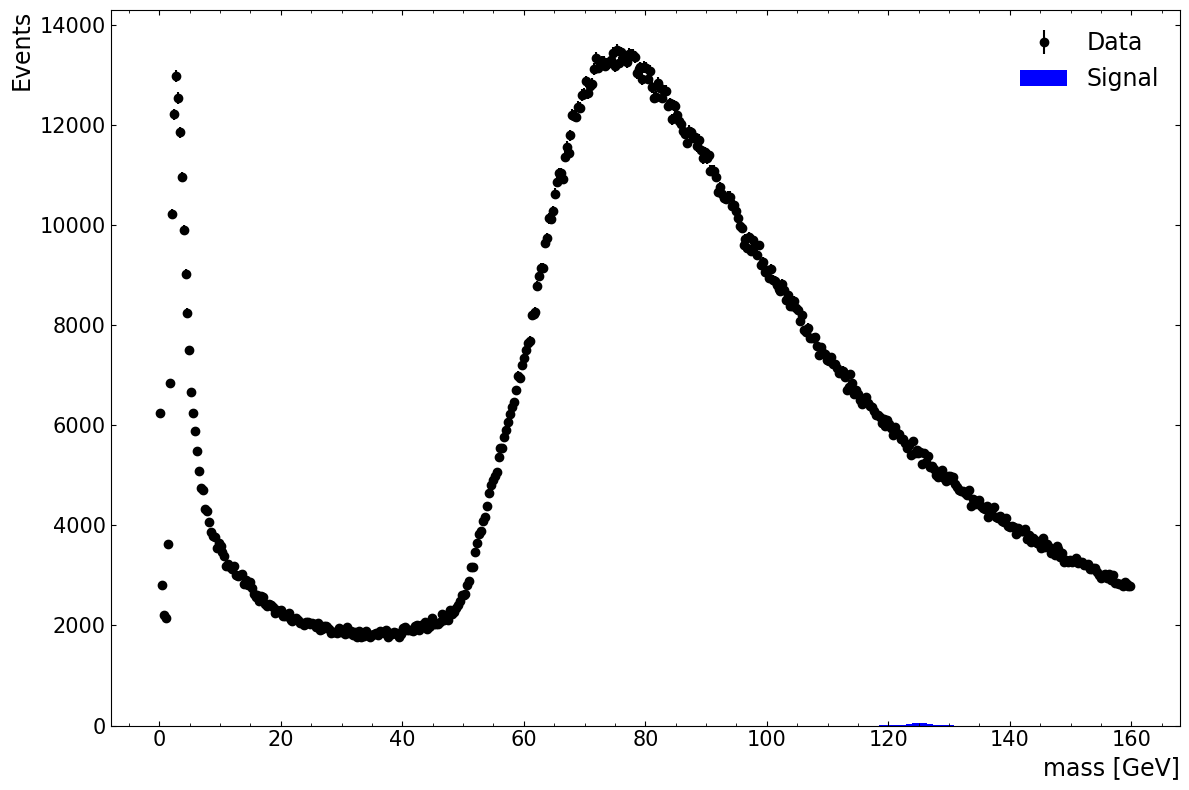

In [7]:
# Define what to plot: 'GamGam' as data, 'Hyy' as signal
plot_dict = {
    'Data' : data['GamGam_0_1'],
    'Signal' : data['Hyy_0_1']
}

# Variable to plot on the x-axis
plot_variable = 'mass'

# Define plot appearance
color_list = ['k', 'b'] # Black (data), blue (signal)
xmin, xmax = 0, 160 # Define histogram bin range and x-axis limits 
num_bins = 500 # Number of histogram bins
x_label = 'mass [GeV]' # x-axis label 

# Plot the histogram
fig, hists = plot_stacked_hist(plot_dict, plot_variable, color_list,
                               num_bins, xmin, xmax, x_label)

The `plot_stacked_hist` function accepts several optional parameters that allow you to customise the appearance and behaviour of the plot:
- `y_label` : Label for the y-axis
- `ylim` : Tuple of two numbers for y-axis limits
- `logy` : Set to `True` to use a logarithmic y-axis
- `title` : Title of the plot
- `marker` : Marker style for the data points (default: `'o'`)
- `fig_size` : Tuple of two numbers for the figure size (default: `(12, 8)`)
- `show_text` : Set to `True` to display text annotations (histogram information) on the plot
- `show_back_unc` : Set to `False` to hide background uncertainty
- `save_fig` : Set to `True` to save the figure
- `fig_name` : String filename to save the plot as an image
- `residual_plot` : Set to `True` to add a residual plot (Data / MC) below the main plot
- `residual_plot_ylim` : Tuple of two numbers for residual plot y-axis limits
- `title_fontsize` : Font size for the plot title (default: 17)
- `label_fontsize` : Font size for the x and y axis labels (default: 17)
- `legend_fontsize` : Font size for the legend (default: 17)
- `tick_labelsize` : Font size for the axis tick labels  (default: 15)
- `text_fontsize` : Font size for text annotations (default: 14)

The function returns a `Figure` object and a **list** of `Hist` objects corresponding to each dataset. 

## Hist
`Hist` objects can be used to inspect the histogram contents, including the bin values, variances (for MC datasets), and underflow/overflow bins.  
The second value returned by `plot_stacked_hist` is a list of `Hist` objects. Their order matches the order of the string codes in `string_code_list`.

Here are some useful methods:
- `.sum()` - total sum of all bin contents
- `.view()` - bin values (Data)
- `.view().value` - bin values (MC)
- `.view().variance` - bin variance (MC)
- `.view(flow=True)[0]` - underflow bin value
- `.view(flow=True)[-1]` - overflow bin value
- `.axes[0].centers` - bin centres
  
For example, try uncommenting the lines below to explore the contents of a `Hist` object:

In [8]:
# In our example, the first Hist object (index 0) is Data, and the second (index 1) is MC
hists[0]                 # View the full histogram object
# hists[0].sum()         # Total sum of all bin contents
# hists[0].view()        # Access the bin values (excluding flow bins)

Hist(Regular(500, 0, 160, name='Data'), storage=Double()) # Sum: 3041429.0 (3627752.0 with flow)

For more information about `Hist`, see https://hist.readthedocs.io/en/latest/.

## Fitting
The `get_histogram` function returns the histogram values, associated variances, and bin centres. The histogram values of the data can be used to fit to a model — typically a polynomial model for the 'background' and a Gaussian for the Higgs mass peak.

For fitting using the `lmfit` library, you may refer to the documentation: https://lmfit.github.io/lmfit-py/.

In [9]:
# Set histogram parameters
num_bins = 200 
xmin, xmax = 110, 160

# Extract mass data from GamGam events
data_mass = data['GamGam_0_1']['mass']
data_hist_name = 'data mass'

# Get histogram values and bin centres - in this case, the variance is not needed
data_x, _, bin_centres = get_histogram(data_mass, num_bins,
                                       xmin, xmax, data_hist_name)
data_x_err = np.sqrt(data_x) # Statistical uncertainties (Poisson)

In [10]:
# Define model components
polynomial_model = PolynomialModel(4) # 4th order polynomial
gaussian_model = GaussianModel() # Gaussian

# Set initial guesses for polynomial parameters:
# c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
parameters = polynomial_model.guess(
    data_x, # data to use to guess parameter values
    x=bin_centres, c0=max(data_x), c1=0, c2=0, c3=0, c4=0
)

# Set initial guesses for Gaussian peak
parameters += gaussian_model.guess(
    data_x, # data to use to guess parameter values
    x=bin_centres, amplitude=100, center=125, sigma=2
)

# Combine the models
model = polynomial_model + gaussian_model

# Fit the model to the data
out = model.fit(data_x, # data to be fit
                parameters, # guesses for the parameters
                x=bin_centres, weights=1/data_x_err) #ASK

# Extract background parameters from the fit result
params_dict = out.params.valuesdict()
c0 = params_dict['c0']
c1 = params_dict['c1']
c2 = params_dict['c2']
c3 = params_dict['c3']
c4 = params_dict['c4']

# Get the background-only part of the fit to data
background = (c0 + c1*bin_centres + c2*bin_centres**2 +
              c3*bin_centres**3 + c4*bin_centres**4)

# Extract the full best-fit curve (background + signal)
fit = out.best_fit

The resulting best-fit curve can be overlaid on the plot by passing it to the `plot_stacked_hist` function via the `fit` argument.  
You can customise how the fit is displayed using the optional parameters:
- `fit_fmt` : linestyle and color for the fit (default is `'-r'` for a red solid line)
- `fit_label` : legend label for the fit (default is `'fit'`)

Elapsed time = 0.2s


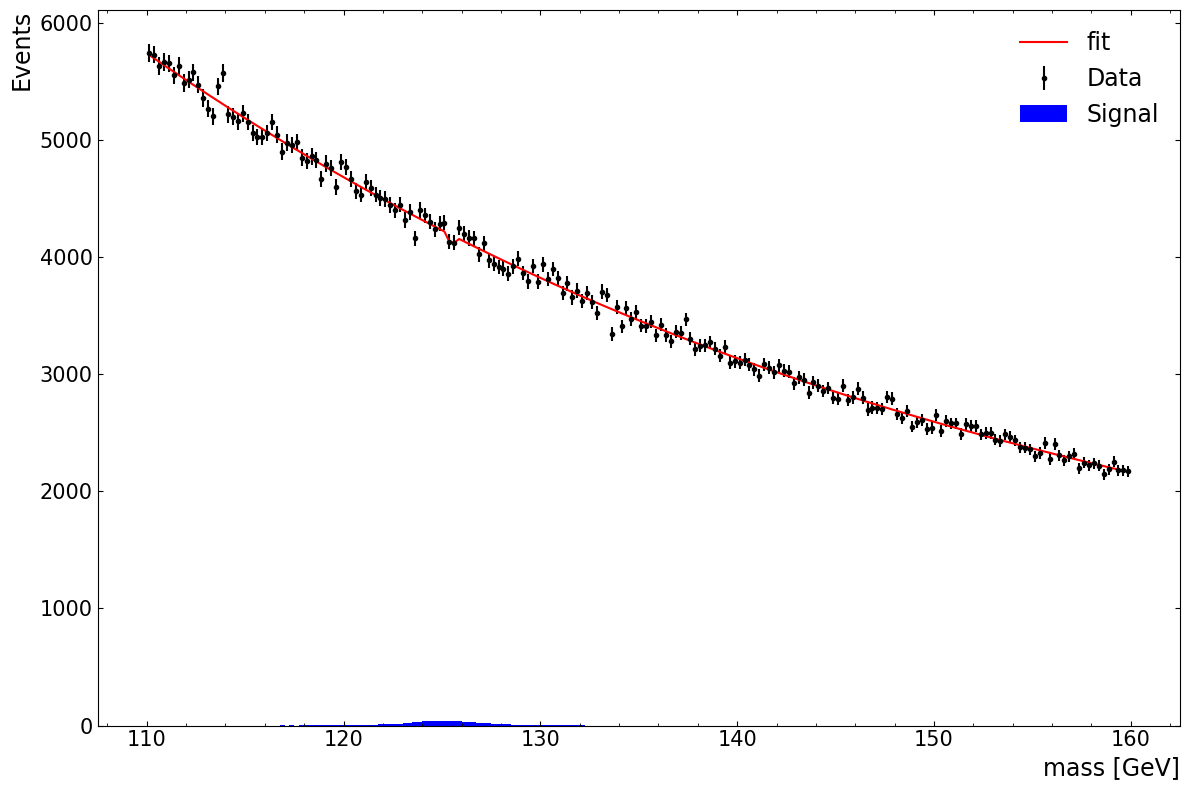

In [11]:
# Use the same num_bins, xmin, xmax as the ones used to find the fit
fig, hist = plot_stacked_hist(
    plot_dict, plot_variable, color_list,
    num_bins, xmin, xmax, x_label,
    fit=fit, marker='.')

If you take a closer look, you might notice a *dip* in the mass distribution rather than a peak! This suggests that the current selection cuts may not be sufficient to suppress background, or that more data is needed.

Perhaps you may want to plot additional variables to identify where the selection cut could be tightened. You can use the `plot_histograms` function, as shown in the example below.  
Note that this function returns:
- A **list** of `Figure` objects (one per variable plotted)
- A corresponding **list of lists** of `Hist` objects

Elapsed time = 0.4s


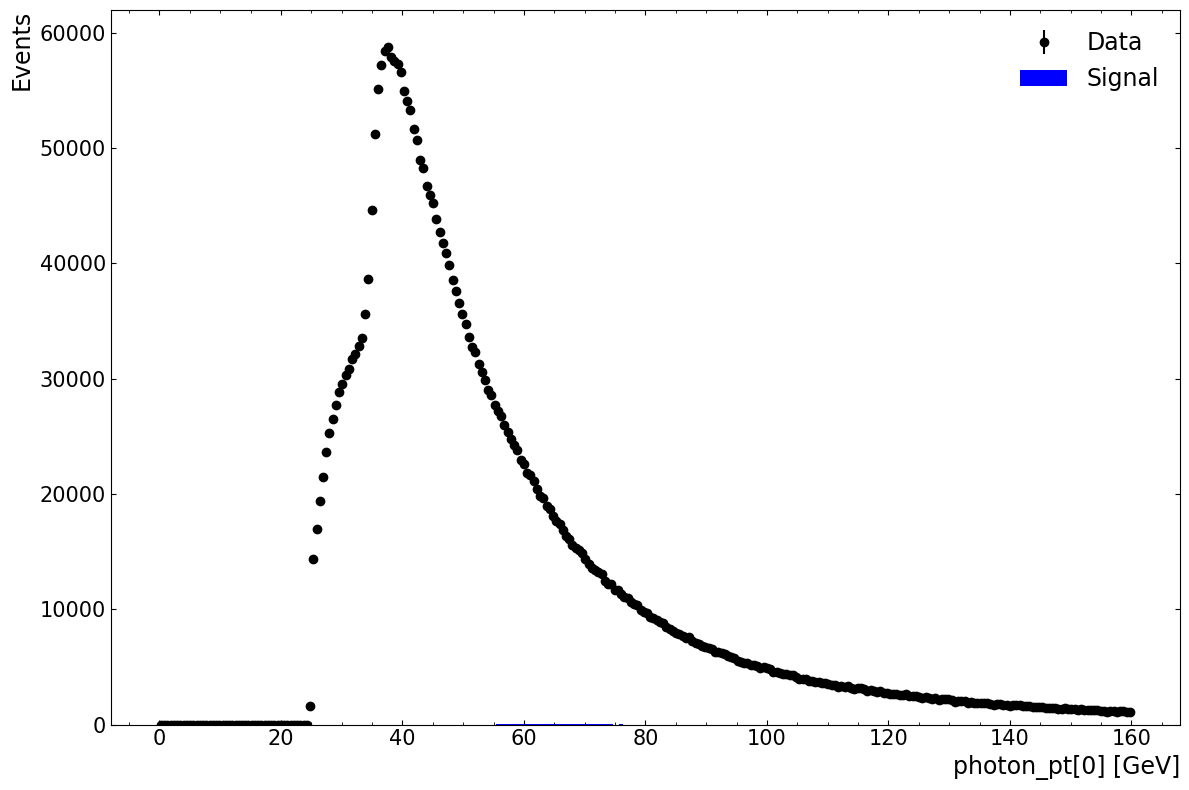

Elapsed time = 1.1s


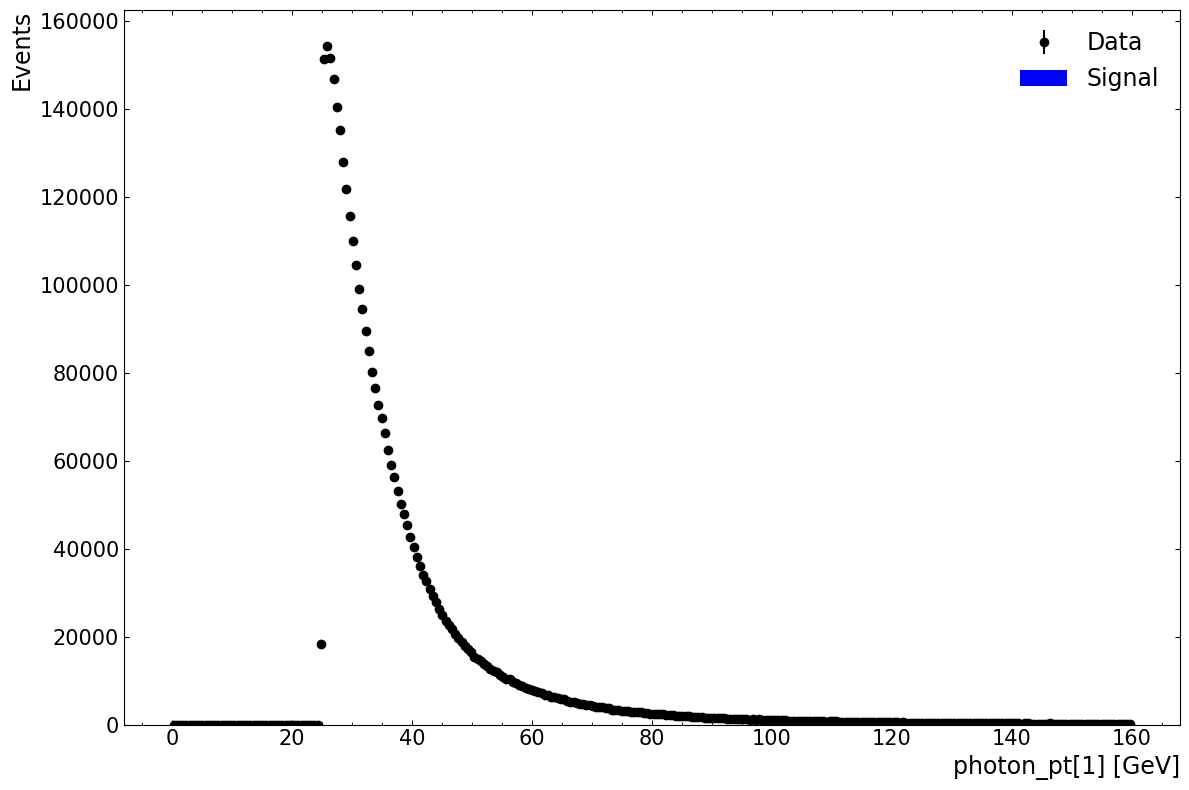

Elapsed time = 2.1s


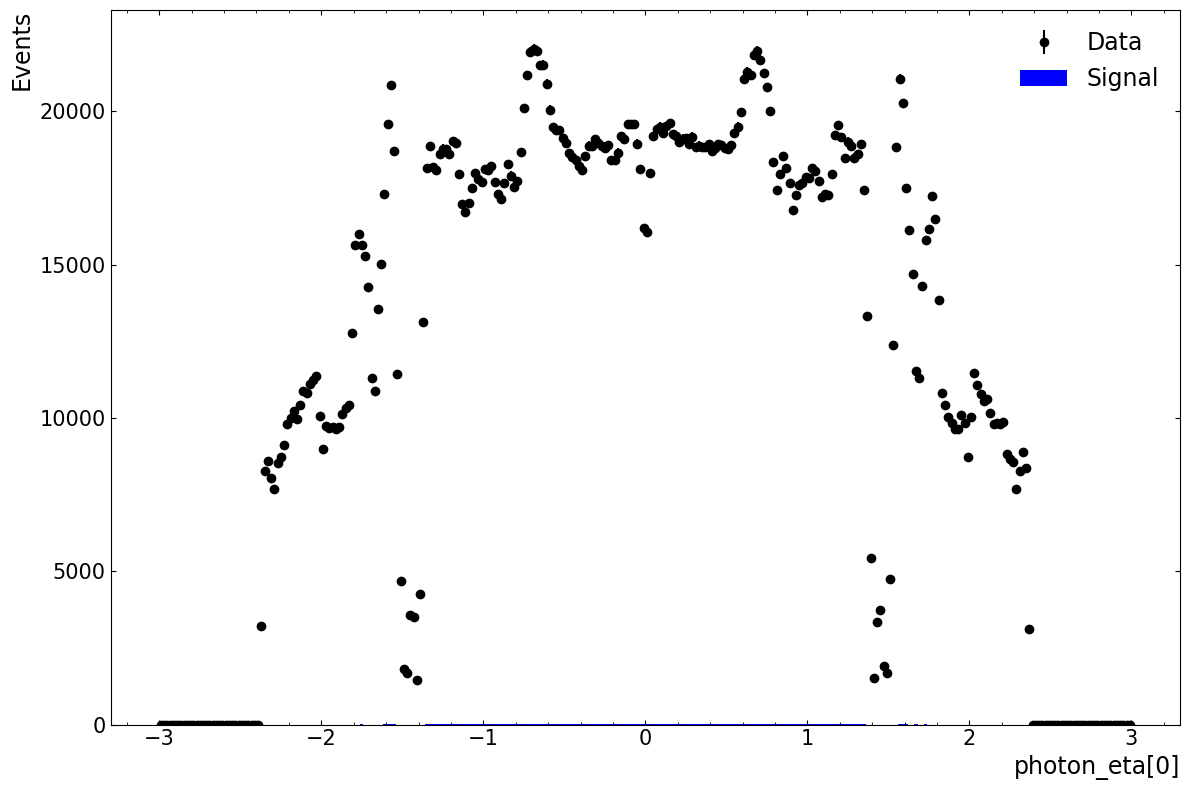

Elapsed time = 2.9s


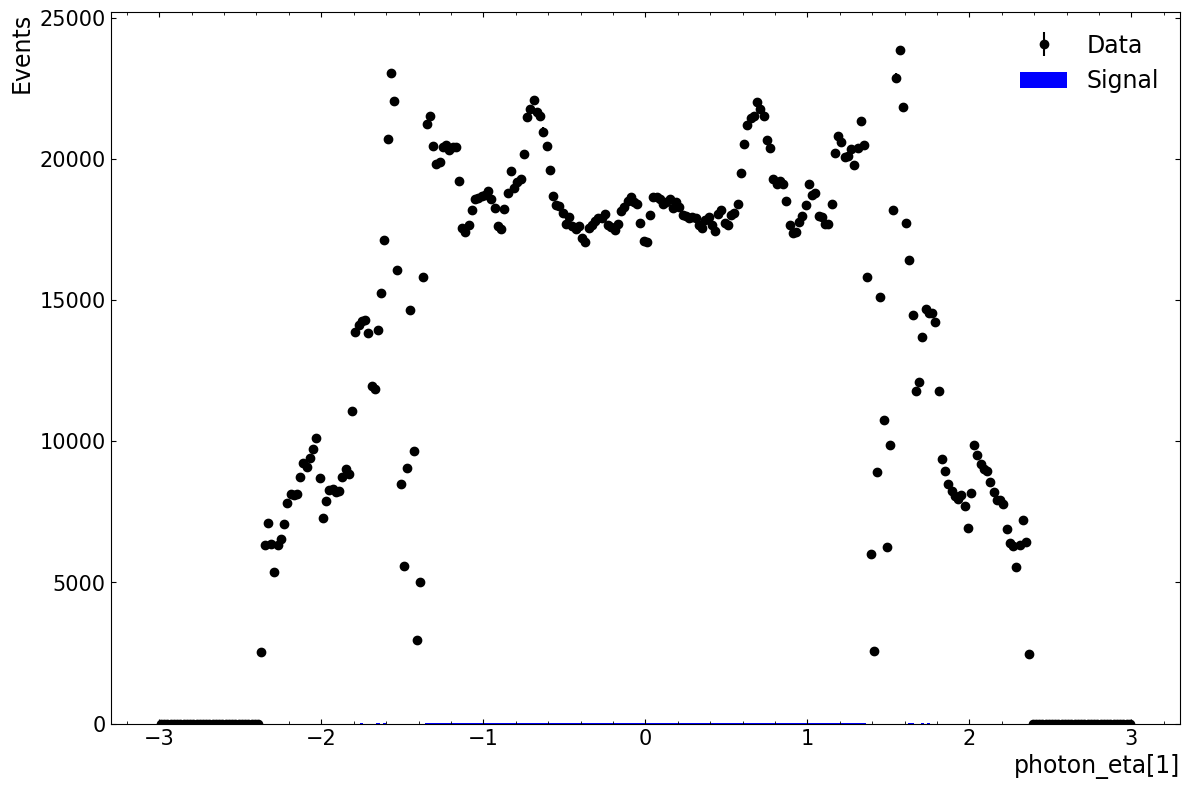

([<Figure size 1200x800 with 1 Axes>,
  <Figure size 1200x800 with 1 Axes>,
  <Figure size 1200x800 with 1 Axes>,
  <Figure size 1200x800 with 1 Axes>],
 [[Hist(Regular(300, 0, 160, name='Data'), storage=Double()) # Sum: 3523311.0 (3627752.0 with flow),
   Hist(Regular(300, 0, 160, name='Signal'), storage=Weight()) # Sum: WeightedSum(value=797.527, variance=16.9594) (WeightedSum(value=813.727, variance=17.3021) with flow)],
  [Hist(Regular(300, 0, 160, name='Data'), storage=Double()) # Sum: 3613744.0 (3627752.0 with flow),
   Hist(Regular(300, 0, 160, name='Signal'), storage=Weight()) # Sum: WeightedSum(value=812.814, variance=17.2828) (WeightedSum(value=813.727, variance=17.3021) with flow)],
  [Hist(Regular(300, -3, 3, name='Data'), storage=Double()) # Sum: 3627752.0,
   Hist(Regular(300, -3, 3, name='Signal'), storage=Weight()) # Sum: WeightedSum(value=813.727, variance=17.3021)],
  [Hist(Regular(300, -3, 3, name='Data'), storage=Double()) # Sum: 3627752.0,
   Hist(Regular(300, -3, 

In [12]:
# Plot many variables at once 
plot_variables = ['photon_pt[0]', 'photon_pt[1]', 'photon_eta[0]', 'photon_eta[1]']
xmin_xmax_list = [(0, 160), (0, 160), (-3, 3), (-3, 3)] # Bin range for each variable
color_list = ['k', 'b'] # Black (data) and blue (MC)
num_bins_list = 300 # If you give an int instead of a list, this number of bins will be applied to all variables
x_label_list = ['photon_pt[0] [GeV]', 'photon_pt[1] [GeV]', 'photon_eta[0]', 'photon_eta[1]']

plot_histograms(
    plot_dict,
    plot_variables,
    color_list,
    xmin_xmax_list, # If you provide a tuple of 2 numbers, that will be applied to all plots
    num_bins_list,
    x_label_list,
    # Optional arguments start from here
    # y_label_list=None, # Str or list of str for y-axis label
    # ylim_list=None, # Tuple of 2 numbers or list of tuples for y axis limit
    # logy=False, # Whether to set the y axis as log scale
    # title_list=None, # Str or list of str for title
    # marker='o', # Marker type
    # title_fontsize=17, # Fontsize for title
    # label_fontsize=17, # Fontsize for x and y axes
    # legend_fontsize=17, # Fontsize for legend
    # tick_labelsize=15, # Fontsize for x and y axes ticks
    # text_fontsize=14, # Fontsize for text that shows histogram info
    # fig_size=(12, 8), # Figure size
    # show_text=False, # Whether to show the text that displays histogram info
    # show_back_unc=True, # Whether to show the background uncertainty
    # residual_plot=False # Whether to show residual plot under the main plot
    # residual_ylim_list=None # Tuple of 2 numbers or list of tuples for residual plot y-axis limit
)         

There are some arguments worth pointing out:
- `xmin_xmax_list` : a tuple of two numbers applied to all plots, or a list of tuples (one per variable)
- `num_bins_list` : an int applied to all plots, or a list of int (one per variable)

The same applies to these optional arguments: `y_label_list`, `ylim_list`, `title_list`, and `residual_ylim_list`. These can be specified as a single value applied to all plots or as a list matching the number of variables.

## Write the Data to Disk
When working with larger datasets, e.g. using a higher `fraction` in `analysis_parquet`, it is often more efficient to write the data to disk rather than keeping it all in memory. 

To do this, set the optional argument `write_parquet=True`. This will instruct the `analysis_parquet` function to save the output as Parquet files. If you write data to disk, it is recommended to set `return_output=False` to avoid loading large amounts of data into memory.  

In addition, you can customise the output location using the `output_directory` argument. If not provided, the files will be saved in an `output` folder with a unique name created from the current date and time.  

**Note**: The provided output directory must be unique and cannot be reused. Attempting to write to an existing directory will raise a `FileExistsError` to prevent accidental overwriting of data.   

In [14]:
read_variables = get_valid_variables('GamGam') # Save all available variables
output_dir = 'output/test0'

analysis_parquet(read_variables, string_code_list, fraction=1,
                cut_function=yy_cut, write_parquet=True,
                output_directory=output_dir, return_output=False)

Write data to output_directory: output/test0
Input string_code_list found. Data samples will be accessed by the string code(s).
Elapsed time = 54.4s


Files saved by `analysis_parquet` can be reloaded using the same function by specifying the following optional arguments:
- `read_directory` : Path to the directory where the data is saved.
- `subdirectory_names` : A list of subdirectories (folder names) to read from. If not provided, all subdirectories in `read_directory` will be read.
  
Note that `string_code_list` is also an optional argument with a default of `None`. Either `string_code_list` _**or**_ `read_directory` must be provided to the `analysis_parquet` function.  

**_Tip_**: Before loading large datasets, it is recommended to restart the kernel to free up memory. Avoid reading too many variables at once to reduce memory usage.

In [15]:
read_directory = 'output/test0' # Directory where data is saved
read_variables = ['mass'] # Variables to read
mass = analysis_parquet(read_variables, string_code_list=None, read_directory=read_directory,
                        subdirectory_names=None, fraction=1, cut_function=None,
                        write_parquet=False, output_directory=None, return_output=True)
mass

Input read_directory found. Data will be read from output/test0.
Elapsed time = 2.1s


{'Hyy_1 x1': <Array [{totalWeight: 0.0201, ...}, ..., {...}] type='389506 * {totalWeight...'>,
 'GamGam_1 x1': <Array [{mass: 160}, {...}, ..., {mass: 24}] type='36272324 * {mass: float32}'>}

Note the 'change' in the keys of the output dictionary. Each key is constructed by combining the subdirectory name with the `fraction`, separated with`' x'`.  
For example, if the subdirectory name is `'Hyy_0_1'` and `fraction = 0.1`, the resulting key will be `'Hyy_0_1 x0_1'`, implying that the sample represents `0.1 × 0.1` of the original dataset.  
However, this naming convention does not reflect whether any cuts have been applied, hence the actual number of events is likely not this fraction of the full data —  it only provides a rough estimate. So, make sure to **record** your output directories and cuts clearly in your lab book!

## 2D Histogram
If you want to plot a 2D histogram, you can use the `histogram_2d` function as shown in the code cell below.

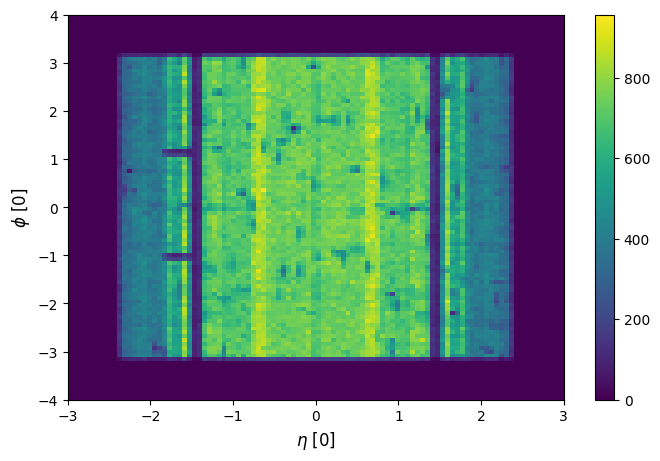

(<Figure size 800x500 with 2 Axes>,
 Hist(
   Regular(100, -3, 3, underflow=False, overflow=False, name='$\\eta$ [0]'),
   Regular(100, -4, 4, underflow=False, overflow=False, name='$\\phi$ [0]'),
   storage=Double()) # Sum: 3627752.0)

In [16]:
# eta and phi of the first photon (index 0) in each event
data_eta0 = data['GamGam_0_1']['photon_eta'][:, 0]
data_phi0 = data['GamGam_0_1']['photon_phi'][:, 0]

data_2d = (data_eta0, data_phi0) # Plot eta on x-axis, phi on y-axis
num_bins_2d = (100, 100) # Number of bins along x and y-axis 
min_max_2d = ((-3, 3), (-4, 4)) # The bin range in x and y
label_2d = ('$\\eta$ [0]', '$\\phi$ [0]') # The labels for x and y-axis

# Plot the 2D histogram
histogram_2d(data_2d, num_bins_2d,
             min_max_2d, label_2d,
             # Optional arguments
             # label_fontsize=12, tick_labelsize=10,
             # title_fontsize=13, title='',
             # colorbar_label='Events'
            )